![title](images/header.png)

# Va - Merging esbae with CEO phase I data 
-------
This notebook merges validated data from CEO data (2015-2020) with the eSBAE data for supervised classification of eSBAE points  
This script requires minimum an m16 instance and select the python 3 kernel
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)


from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### 1. combine all CEO sample files
##### download the CEO phase I sample file from here: https://drive.google.com/file/d/1NjQ--y9w3LzwoZSKUN19LDWwN-92lLeh/view?usp=sharing
##### and upload to SEPAL using FileZilla.

In [2]:
ceo1 = pd.read_csv('/home/sepal-user/CAFI_DDD/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
ceo1.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,Ref_Chan_1,countDrive,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_ChDate,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,2018.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg_2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,2020.0,2,0,0,1,0,1,0,0,0,0,ceo,Deg_2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,2020.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg_2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,5


In [3]:
column_names = ceo1.columns.tolist()
# Print the list of column names
print(column_names)

['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co', 'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source', 'Ref_ChDate', 'Change_Bin', 'UniqueID']


##### add a column named "interpreted" which = 1 when the point has been validated in CEO, otherwise 0
##### count the number of validated points per ceo file
##### replace forest and non-forest types with codes

In [4]:
# Add 'collection' column with an increasing number
ceo1['collection'] = 0
    
# Add 'interpreted' column with 1 when 'email' is not null, otherwise 0
ceo1['interpreted'] = 1
    
# Calculate total count for each 'interpreted' value
interpreted_counts = ceo1['interpreted'].value_counts().to_dict()
    
# Create a dictionary to map old column names to new column names
column_mapping = {
    'Ref_FNF': 'Ref_FNF_2015',
    'Ref_LCover': 'Ref_LCtype', 
    'Ref_Change': 'Ref_Change_Type_1520', 
    'Ref_Chan_1': 'Ref_Year',
    'Change_Bin': 'Ref_Change_1520',
    'Ref_ChDate': 'Ref_Change_Year_1520',
    'countDrive': 'countDrivers'
}

# Use the rename() method to rename the columns
ceo_phaseI = ceo1.rename(columns=column_mapping)

ceo_phaseI['Ref_Change_Year_1520'] = ceo_phaseI['Ref_Change_Year_1520'].str.replace('_', '', regex=True)
ceo_phaseI.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Change_Type_1520,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520,UniqueID,collection,interpreted
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,2018.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2018,1,1,0,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,2020.0,2,0,0,1,0,1,0,0,0,0,ceo,Deg2020,1,2,0,1
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,2020.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2020,1,3,0,1
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,4,0,1
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,5,0,1


In [5]:
ceo_column_names = ceo_phaseI.columns.tolist()
# Print the list of column names
print(ceo_column_names)

['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co', 'Ref_FNF_2015', 'Ref_LCtype', 'Ref_Change_Type_1520', 'Ref_Year', 'countDrivers', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source', 'Ref_Change_Year_1520', 'Ref_Change_1520', 'UniqueID', 'collection', 'interpreted']


In [6]:
ceo_phaseI['Ref_FNF_2015'].value_counts()

Ref_FNF_2015
1    8509
0    4606
Name: count, dtype: int64

In [7]:
ceo_phaseI['Ref_Change_1520'].value_counts()

Ref_Change_1520
0    9275
1    3840
Name: count, dtype: int64

In [8]:
ceo_phaseI['Ref_Change_Type_1520'].value_counts()

Ref_Change_Type_1520
Stable    4669
NF        4606
Def       2541
Deg       1299
Name: count, dtype: int64

In [9]:
ceo_phaseI['Ref_LCtype'].value_counts()

Ref_LCtype
1     3502
13    1453
3     1306
16    1202
15    1068
4      893
12     812
9      686
2      529
19     477
11     428
14     187
17     181
8      166
7      166
18      33
10      21
0        5
Name: count, dtype: int64

In [10]:
ceo_phaseI['Def2016'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2016', 1, 0)
ceo_phaseI['Def2017'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2017', 1, 0)
ceo_phaseI['Def2018'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2018', 1, 0)
ceo_phaseI['Def2019'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2019', 1, 0)
ceo_phaseI['Def2020'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2020', 1, 0)

In [11]:
ceo_phaseI['Deg2016'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2016', 1, 0)
ceo_phaseI['Deg2017'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2017', 1, 0)
ceo_phaseI['Deg2018'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2018', 1, 0)
ceo_phaseI['Deg2019'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2019', 1, 0)
ceo_phaseI['Deg2020'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2020', 1, 0)

In [12]:
ceo_phaseI['Defall'] = np.where(ceo_phaseI['Ref_Change_Type_1520'] == 'Def', 1, 0)
ceo_phaseI['Degall'] = np.where(ceo_phaseI['Ref_Change_Type_1520'] == 'Deg', 1, 0)

In [13]:
ceo_phaseI['Stable'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Stable', 1, 0)
ceo_phaseI['NF'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'NF', 1, 0)

In [14]:
#export cleaned CEO data
ceo_phaseI_out = '/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean.csv'
ceo_phaseI.to_csv(ceo_phaseI_out,index=True)

In [15]:
ceo_phaseI.columns

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF_2015', 'Ref_LCtype', 'Ref_Change_Type_1520', 'Ref_Year',
       'countDrivers', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg',
       'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other',
       'Source', 'Ref_Change_Year_1520', 'Ref_Change_1520', 'UniqueID',
       'collection', 'interpreted', 'Def2016', 'Def2017', 'Def2018', 'Def2019',
       'Def2020', 'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020',
       'Defall', 'Degall', 'Stable', 'NF'],
      dtype='object')

### 2. read esbae points with augmented data

In [17]:
#this file can be downloaded from this URL: https://drive.google.com/file/d/1AHtcKLkCUVgs5PKKDtnGAy_9Gf54DHKs/view?usp=sharing
#you can then use FileZilla to upload to your SEPAL
esbae = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_1520.geojson')
esbae.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

##### Rename columns to be same as ceo file 

In [18]:
esbae = esbae.rename(columns={'PLOTID': 'plotid'})
esbae = esbae.rename(columns={'LAT': 'lat'})
esbae = esbae.rename(columns={'LON': 'lon'})

In [19]:
columns_to_drop = ['dates', 'ts']
esbae = esbae.drop(columns=columns_to_drop)

In [20]:
print(esbae.dtypes)

geometry                geometry
UniqueID                   int64
images                     int64
mon_images                 int64
bfast_change_date        float64
bfast_magnitude          float64
bfast_means              float64
cusum_change_date        float64
cusum_confidence         float64
cusum_magnitude          float64
red_mean                 float64
red_sd                   float64
red_min                  float64
red_max                  float64
nir_mean                 float64
nir_sd                   float64
nir_min                  float64
nir_max                  float64
swir1_mean               float64
swir1_sd                 float64
swir1_min                float64
swir1_max                float64
swir2_mean               float64
swir2_sd                 float64
swir2_min                float64
swir2_max                float64
ndfi_mean                float64
ndfi_sd                  float64
ndfi_min                 float64
ndfi_max                 float64
brightness

In [21]:
len(esbae)

13115

In [22]:
eSBAE_cols = esbae.columns
eSBAE_cols

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       

### Merge ceo and sbae tables
#### replace validated points in esbae points

In [23]:
#make list of point_ids of validated points
validated_id_list = ceo_phaseI['UniqueID'].tolist()
len(validated_id_list)

13115

In [24]:
# Merge ceo and sbae on "pointid" with an outer join
esbae_ceo = pd.merge(esbae, ceo_phaseI, on='UniqueID', how='outer')

In [25]:
len(esbae_ceo)

13115

In [26]:
esbae_ceo.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Change_Type_1520,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520,collection,interpreted,Def2016,Def2017,Def2018,Def2019,Def2020,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF
0,POINT (25.60212 -11.69189),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,5133.624472,3501.853926,-1819.142857,9460.5,-301.736261,234.765711,394.326497,-965.383324,17082,1,-1169.944586,0,0,-0.634851,0,0,-0.923201,2020.145,2051.634523,231,1.0,72.0,12.0,14.0,57.0,1421.446655,10,10,2,2,2,2.0,2,0,0,NaN,51,12.0,11,1,6,6,6,6,6,0.0,0.0,70.0,91.0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,2018.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2018,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,POINT (19.01298 6.40494),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,6195.335066,3350.258588,-2265.250000,9933.0,690.942090,197.601505,1291.894621,113.604139,16883,1,-1732.288015,0,0,0.400286,0,0,-2.235080,2016.205,-2895.941193,331,1.0,75.0,10.0,19.0,56.0,516.865479,10,10,2,2,2,2.0,2,0,0,NaN,58,23.0,11,1,6,6,6,6,6,0.0,0.0,70.0,91.0,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,2020.0,2,0,0,1,0,1,0,0,0,0,ceo,Deg2020,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,POINT (22.79183 7.07841),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,3309.624219,3680.730569,-3014.428571,9884.0,530.790096,227.729392,1428.179686,-175.227796,17182,1,2044.706403,18302,1,1.916829,16806,1,0.562759,0.000,0.000000,6,1.0,74.0,4.0,12.0,40.0,647.862305,10,10,11,11,2,11.0,11,0,0,NaN,40,16.0,3,2,6,6,6,6,6,0.0,0.0,70.0,91.0,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,2020.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2020,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,POINT (27.43010 -6.53484),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,6379.879405,2973.335573,-198.333333,9529.0,6379.879405,2973.335573,-198.333333,9529.0,6379.87940

#### clean up _x and _y columns

In [27]:
merged_columns = esbae_ceo.columns.tolist()
print(merged_columns)

['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 

In [28]:
print(esbae_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [29]:
esbae_ceo['interpreted'] = esbae_ceo['interpreted'].fillna(0)
esbae_ceo['interpreted'] = esbae_ceo['interpreted'].astype(int)
esbae_ceo['interpreted'].value_counts(dropna=False)

interpreted
1    13115
Name: count, dtype: int64

In [30]:
esbae_ceo['Ref_Change_Year_1520'].value_counts(dropna=False)

Ref_Change_Year_1520
Stable     4669
NF         4606
Def2017     765
Def2018     734
Def2016     539
Deg2017     440
Def2019     362
Deg2018     328
Deg2016     280
Deg2019     150
Def2020     141
Deg2020     101
Name: count, dtype: int64

#### check for missing values and fill NAs

In [36]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = esbae_ceo[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_ma

In [33]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_gain','gfc_lossyear', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
esbae_ceo[columns_to_fill] = esbae_ceo[columns_to_fill].fillna(0)

In [35]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = esbae_ceo[column].mean()
    esbae_ceo[column].fillna(mean_value, inplace=True)

##### plot deforestation points by year

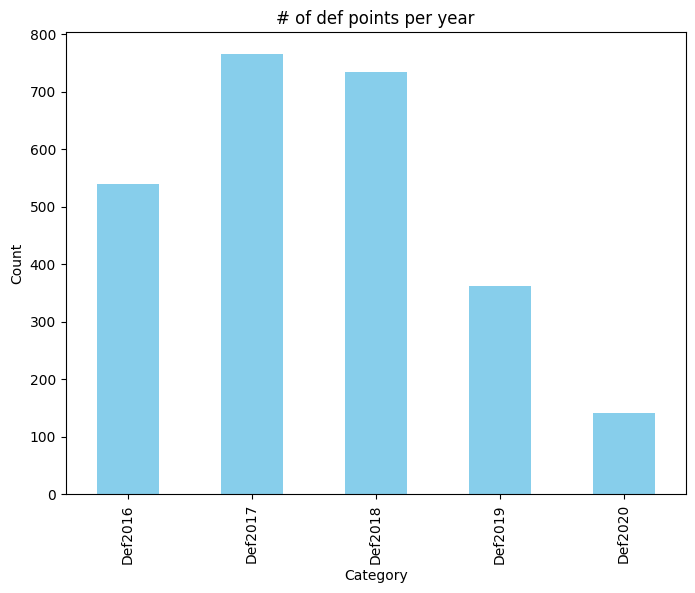

In [37]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020']

# Filter the DataFrame to include only the selected values
filtered_df = esbae_ceo[esbae_ceo['Ref_Change_Year_1520'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Ref_Change_Year_1520'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

##### plot degradation points by year

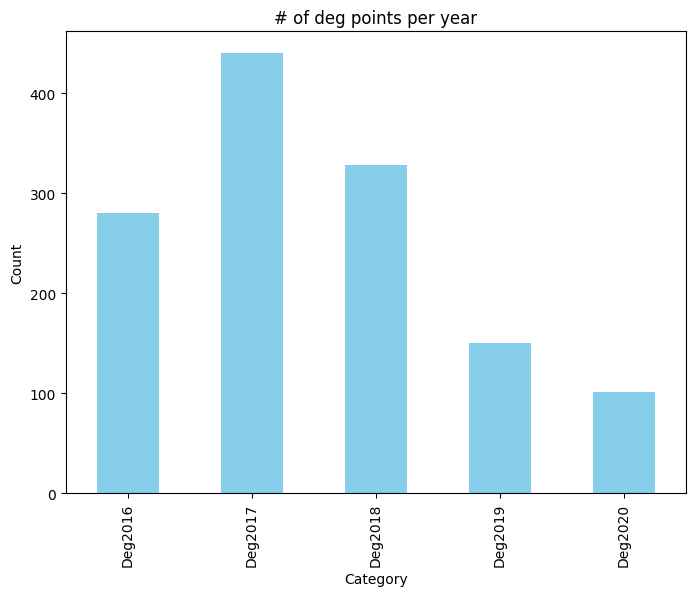

In [38]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020']

# Filter the DataFrame to include only the selected values
filtered_df = esbae_ceo[esbae_ceo['Ref_Change_Year_1520'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
degvalue_counts = filtered_df['Ref_Change_Year_1520'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
degvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [39]:
print(esbae_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [40]:
merged_annual_counts = esbae_ceo['Ref_Change_Year_1520'].value_counts()
merged_annual_counts = merged_annual_counts.sort_index()
merged_annual_counts

Ref_Change_Year_1520
Def2016     539
Def2017     765
Def2018     734
Def2019     362
Def2020     141
Deg2016     280
Deg2017     440
Deg2018     328
Deg2019     150
Deg2020     101
NF         4606
Stable     4669
Name: count, dtype: int64

In [41]:
esbae_ceo.describe()

,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,OID_,PLOTID,LON,LAT,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Ref_Change_1520,collection,interpreted,Def2016,Def2017,Def2018,Def2019,Def2020,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF
count,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,3840.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.0,13115.0,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.00000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000
mean,6558.024552,120.081662,66.287076,1811.985737,-979.246390,-1.702914e+07,2018.205956,0.346680,46264.252877,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,5557.249108,2695.950804,58.044797,9597.848599,-137.044018,1.921784e+02,494.674982,-763.916422,14260.462600,0.835532,-171.971127,13333.094319,0.768052,-4.365190e+10,13103.314297,0.765612,-2.076375e+10,1150.610225,-753.058351,178.638201,1.853240,69.356636,14.456460,13.857666,47.177746,747.505520,21.134579,20.621426,4.221731,4.715898,4.832939,4.849867,4.850019,0.007244,0.339840,6.376744,59.058330,14.977888,9.113839,5.004880,3.661914,3.727640,3.787190,3.811056,3.830042,429.201982,340.500419,45.616546,56.293404,6557.000000,167870.325963,19.508425,0.176108,59.902783,0.648799,7.996111,2017.519010,0.776210,0.151735,0.114602,0.254594,0.0233

In [42]:
print(esbae_ceo.dtypes)

geometry                geometry
UniqueID                   int64
images                     int64
mon_images                 int64
bfast_change_date        float64
bfast_magnitude          float64
bfast_means              float64
cusum_change_date        float64
cusum_confidence         float64
cusum_magnitude          float64
red_mean                 float64
red_sd                   float64
red_min                  float64
red_max                  float64
nir_mean                 float64
nir_sd                   float64
nir_min                  float64
nir_max                  float64
swir1_mean               float64
swir1_sd                 float64
swir1_min                float64
swir1_max                float64
swir2_mean               float64
swir2_sd                 float64
swir2_min                float64
swir2_max                float64
ndfi_mean                float64
ndfi_sd                  float64
ndfi_min                 float64
ndfi_max                 float64
brightness

In [43]:
esbae_ceo['sampling'] = 'str_random'

##### export merged esbae and ceo data to one csv file

In [44]:
esbae_ceo_data_out =  '/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_merge.csv'
esbae_ceo.to_csv(esbae_ceo_data_out,index=False)